In [10]:
import collections as c, numpy as np, scipy.stats as sct, pandas as pd, networkx as nx
from matplotlib import pyplot as plt
import copy, time, math

In [2]:
def gammalog(x):
    return sum(np.log(range(1,int(x))))

In [3]:
def make_graph(parents):
    graph = np.matrix([[0,0]])
    for i in parents.keys():
        for j in parents[i]:
            if len(parents[i]) != 0:
                graph = np.append(graph, [[j, i]], axis=0)
    graph = np.delete(graph, 0, axis=0)
    return graph

In [128]:
def cycle_check(parents, ik_map):
    
    g = make_graph(parents)
    test = nx.DiGraph()
    test.add_nodes_from([i for i in range(len(ik_map))])    
    
    parents = [ik_map[i[0]][0] for i in g.tolist()]
    children = [ik_map[i[1]][0] for i in g.tolist()]
    
    for i in range(len(parents)):
        test.add_edge(parents[i], children[i])
    
    try:
        cycle = list(nx.find_cycle(test, orientation='original'))
    except:
        cycle = []
        
    return cycle

In [4]:
def b_score(data, parents, values):
    
    m, m_totes, alpha_totes = c.defaultdict(int), c.defaultdict(int), c.defaultdict(int)
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            k = data[i,j]
            if len(parents[j]) == 0:
                parent_k = -1
            else:
                parent_k = tuple([data[i,z] for z in range(data.shape[1]) if z in parents[j]])
            m[j, parent_k, k] += 1
            m_totes[j, parent_k] += 1
    
    for key in m_totes.keys():
        alpha_totes[key] = len(values[key[0]])
    
    a = np.sum([gammalog(m[i]+1) for i in m.keys()])
    b = np.sum([-1*gammalog(alpha_totes[i] + m_totes[i]) \
                + gammalog(alpha_totes[i]) for i in m_totes.keys()])
    return a + b

In [119]:
def K2(data, parents, values, ik_map):
    
    m, n = data.shape
    res = b_score(data, parents, values)
    random1 = list(np.random.choice(n, n, replace = False))
    
    for i in range(n):
        count = 0
        child = random1[i]
        random2 = list(np.random.choice(n, n, replace = False))
        for j in range(n):
            parent = random2[j]
            if (parent not in parents[child] and child not in parents[parent] and parent != child and count <= 6):
                parents[child] += [parent]
                cycle = cycle_check(parents, ik_map)
                if len(cycle) == 0:
                    test = b_score(data, parents, values)
                    if test > res:
                        res = test
                        count += 1
                    else:
                        parents[child].pop()
                else:
                    parents[child].pop()

    return parents, res

In [6]:
def write_gph(dataset, parents, ik_map):
    file = open(dataset + ".gph", "w")
    
    g = make_graph(parents)
    parents = [ik_map[i[0]][1] for i in g.tolist()]
    children = [ik_map[i[1]][1] for i in g.tolist()]
    for i in range(len(parents)):
        edge = parents[i] + "," + children[i] +"\n"
        file.write(edge)

    file.close()

In [129]:
def grapherator(dataset, parents, ik_map):
    
    g = make_graph(parents)    
    res = nx.DiGraph()
    res.add_nodes_from([ik_map[i][1] for i in range(len(ik_map))])
    
    parents = [ik_map[i[0]][1] for i in g.tolist()]
    children = [ik_map[i[1]][1] for i in g.tolist()]

    for i in range(len(parents)):
        res.add_edge(parents[i], children[i])
    
    nx.draw(res, with_labels=True, node_color='lightgrey',node_size=1000, font_weight='bold')
    plt.savefig(dataset + '.png')
    plt.show()
    
    try:
        print(list(nx.find_cycle(test, orientation='original')))
    except:
        print('No cycles found! \n')      

In [125]:
def main(burn_in, epsilon, max_iters, dataset):
    
    np.seterr(divide='ignore', invalid='ignore')
    start = time.time()
    
    z = sct.norm.ppf(1 - .05 / 2)
    confidence_interval = np.inf
    running_mean, running_2moment, N = 0, 0, 0
    
    if dataset == 'small':
        df = pd.read_csv('AA228Student/workspace/project1/small.csv')
    elif dataset == 'medium':
        df = pd.read_csv('AA228Student/workspace/project1/medium.csv')
    elif dataset == 'large':
        df = pd.read_csv('AA228Student/workspace/project1/large.csv')
    else:
        return None
    
    data = np.matrix(df)   
    i_map = [(i, df.columns[i]) for i in range(len(df.columns))]
    k_map = [(df[i].nunique(), df[i].unique()) for i in df.columns]
    ik_map = [i_map[i] + k_map[i] for i in range(len(k_map))]
   
    values = {}
    for i in range(len(ik_map)):
        values[i] = ik_map[i][3].tolist()
        
    best_parents = {}
    for i in range(len(df.columns)):
        best_parents[i] = []    
    best_score = -np.inf
    
    while(N < burn_in or confidence_interval >= epsilon) and N < max_iters:
        parents = {}
        for i in range(len(df.columns)):
            parents[i] = []
        parents, score = K2(data, parents, values, ik_map)
        if score > best_score:
            best_score = score
            best_parents = parents

        running_mean = (running_mean * N + score) / (N + 1)
        running_2moment = (running_2moment * N + pow(score, 2)) / (N + 1)
        sample_std = math.sqrt(running_2moment - pow(running_mean, 2))
        confidence_interval = z * sample_std / (math.sqrt(N))
        N += 1
    CI = [running_mean - confidence_interval, running_mean + confidence_interval]
    
    finish = time.time()
    print('Generated', N, 'samples in ', round(finish-start,2), ' seconds \n')
    print('95% Confidence Interval: ', CI)
    
    write_gph(dataset, best_parents, ik_map)
    grapherator(dataset, best_parents, ik_map)
    
    return best_parents, best_score

Generated 1000 samples in  836.15  seconds 

95% Confidence Interval:  [-3837.0233551069791, -3835.4331124726909]


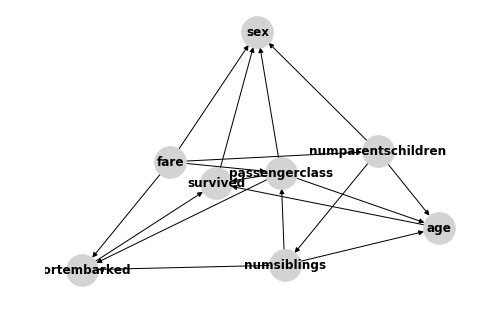

No cycles found! 

{0: [4, 3, 6], 1: [6, 2, 4], 2: [], 3: [2], 4: [2, 6], 5: [3, 4, 7, 2], 6: [3], 7: [4, 0, 1]} 

-3802.47933379


In [130]:
small_parents, small_score = main(5, .05, 1000, 'small')
print(small_parents,'\n')
print(small_score)

In [135]:
836/100

8.36

Generated 500 samples in  9245.69  seconds 

95% Confidence Interval:  [-42522.658301942203, -42490.532325075408]


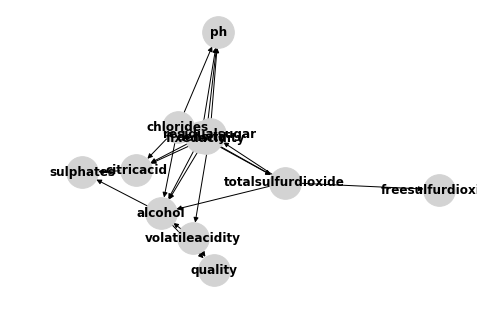

No cycles found! 

{0: [7], 1: [3], 2: [7, 4, 0], 3: [6, 7], 4: [], 5: [6], 6: [0, 7], 7: [], 8: [0, 3, 4, 7], 9: [2, 10], 10: [6, 0, 7, 1, 4], 11: [10, 1]} 

-42013.1032894


In [132]:
medium_parents, medium_score = main(5, .05, 500, 'medium')
print(medium_parents,'\n')
print(medium_score)

In [134]:
9245/500

18.49

Generated 1 samples in  8198.02  seconds 

95% Confidence Interval:  [nan, nan]


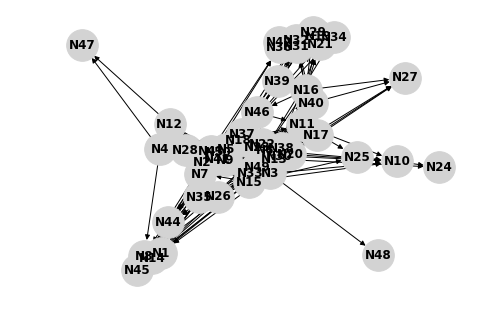

No cycles found! 

{0: [26, 8, 25, 34, 2, 49], 1: [22, 8, 26], 2: [8], 3: [47, 46, 22, 2, 26, 43, 1], 4: [2], 5: [10, 2, 8, 15], 6: [35, 31, 27, 23, 5, 11, 8], 7: [45, 6, 8, 0, 11], 8: [9, 10], 9: [], 10: [9], 11: [10, 8, 1, 20], 12: [2, 43, 48, 8, 5, 14, 40], 13: [5, 30], 14: [5, 35, 34, 15], 15: [33, 2], 16: [15, 8, 20, 9, 11], 17: [15, 19, 18], 18: [33, 15, 19], 19: [33, 15, 20, 30, 21], 20: [2], 21: [26, 14, 2, 3, 5], 22: [], 23: [22, 35, 34, 14], 24: [3, 22], 25: [26, 38, 5, 3, 27, 21], 26: [5, 22, 2], 27: [21, 45, 3, 8, 5], 28: [12, 27], 29: [36, 15, 27, 17, 30, 13], 30: [33], 31: [30, 11, 8, 23], 32: [30, 8, 7, 6, 23, 31], 33: [], 34: [49, 11, 42, 8, 41], 35: [34, 15, 5], 36: [35, 23, 14, 26, 34, 37, 39], 37: [38, 39, 6], 38: [27, 8, 6], 39: [], 40: [44, 26], 41: [26, 44, 40, 42], 42: [45, 8, 26], 43: [42, 14, 15, 2, 47, 44, 41], 44: [26], 45: [11], 46: [8, 40, 34, 22], 47: [2, 46, 22], 48: [8, 14], 49: [2, 8, 11]} 

-453417.958959


In [131]:
large_parents, large_score = main(1, .05, 3, 'large')
print(large_parents,'\n')
print(large_score)

## For README ##

initially tried creating graphs with cycles and then trimming down the cycles to optimize score
    - this resulted in very optimal looking scores but the algorithm would not even finish on the large dataset

then tried monte carlo / confidence interval with creating graphs that were DAGs from the start
    - still wouldn't run on large dataset
    
eventually had to limit the amount of parents that could be assigned to each child in order to get the thing to run

In [133]:
-453417.958959-42013

-495430.958959